In [1]:
import os
import sys
sys.path.append('../../..')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import joblib
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import feature_column as fc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn import preprocessing
from sklearn.utils import shuffle
from tensorflow.keras.models import save_model,load_model
from collections import defaultdict

from utils.util import *
from utils.preprocessing import *
from utils.dataiter import Dataiter
from utils.evaluate import calculate_ctr, compute_rce, average_precision_score
from utils.target_encode import MTE_one_shot

import tensorflow.keras.backend as K
import core.config as conf

## Load Data

In [2]:
path = f'{conf.dataset_mini_path}/train'
train = read_data(path)

path = f'{conf.dataset_mini_path}/test'
test = read_data(path)

path = f'{conf.dataset_mini_path}/valid'
valid = read_data(path)

In [3]:
TARGET = ['like', 'reply', 'retweet', 'comment']

## Preprocessing

In [4]:
def set_dataframe_types(df, train):
    df['id']   = np.arange( df.shape[0] )
    df['id']   = df['id'].astype(np.uint32)

    if train:
        df['reply_timestamp']   = df['reply_timestamp'].fillna(0)
        df['retweet_timestamp'] = df['retweet_timestamp'].fillna(0)
        df['comment_timestamp'] = df['comment_timestamp'].fillna(0)
        df['like_timestamp']    = df['like_timestamp'].fillna(0)

        df['reply_timestamp']   = df['reply_timestamp'].astype(np.uint32)
        df['retweet_timestamp'] = df['retweet_timestamp'].astype(np.uint32)
        df['comment_timestamp'] = df['comment_timestamp'].astype(np.uint32)
        df['like_timestamp']    = df['like_timestamp'].astype(np.uint32)

    df['tweet_timestamp']         = df['tweet_timestamp'].astype( np.uint32 )
    df['creator_follower_count']  = df['creator_follower_count'].astype( np.uint32 )
    df['creator_following_count'] = df['creator_following_count'].astype( np.uint32 )
    df['creator_account_creation']= df['creator_account_creation'].astype( np.uint32 )
    df['engager_follower_count']  = df['engager_follower_count'].astype( np.uint32 )
    df['engager_following_count'] = df['engager_following_count'].astype( np.uint32 )
    df['engager_account_creation']= df['engager_account_creation'].astype( np.uint32 )

    return df



def preprocess(df, target, train):
    df = set_dataframe_types(df, train)
    # df = df.set_index('id')
    # df.columns = conf.raw_features + conf.labels
    df = df.drop('text_tokens', axis=1)
    
    df = feature_extraction(df, features=conf.used_features, train=train) # extract 'used_features'
    cols = []

    return df

In [6]:
train = preprocess(train, TARGET, True)
valid = preprocess(valid, TARGET, True)
test = preprocess(test, TARGET, True)

In [ ]:
train

### pickle matching

#### language

In [7]:
pickle_path = conf.dict_path

In [8]:
user_main_language_path = pickle_path + "user_main_language.pkl"

if os.path.exists(user_main_language_path) :
    with open(user_main_language_path, 'rb') as f :
        user_main_language = pickle.load(f)
        user_main_language = defaultdict(lambda : -1, user_main_language)

In [9]:
language_dict_path = pickle_path + "language_dict.pkl"

if os.path.exists(language_dict_path ) :
    with open(language_dict_path , 'rb') as f :
        language_dict = pickle.load(f)

In [10]:
train['language'] = train.apply(lambda x : language_dict[x['language']], axis = 1)
test['language'] = test.apply(lambda x : language_dict[x['language']], axis = 1)
valid['language'] = valid.apply(lambda x : language_dict[x['language']], axis = 1)

In [11]:
del language_dict

In [12]:
train['creator_main_language'] = train['creator_id'].map(user_main_language)
valid['creator_main_language'] = valid['creator_id'].map(user_main_language)
test['creator_main_language'] = test['creator_id'].map(user_main_language)

In [13]:
train['engager_main_language'] = train['engager_id'].map(user_main_language)
valid['engager_main_language'] = valid['engager_id'].map(user_main_language)
test['engager_main_language'] = test['engager_id'].map(user_main_language)

In [14]:
train['creator_and_engager_have_same_main_language'] = train.apply(lambda x : 1 if x['creator_main_language'] == x['engager_main_language'] else 0, axis = 1)
valid['creator_and_engager_have_same_main_language'] = valid.apply(lambda x : 1 if x['creator_main_language'] == x['engager_main_language'] else 0, axis = 1)
test['creator_and_engager_have_same_main_language'] = test.apply(lambda x : 1 if x['creator_main_language'] == x['engager_main_language'] else 0, axis = 1)

In [15]:
train['is_tweet_in_creator_main_language'] = train.apply(lambda x : 1 if x['creator_main_language'] == x['language'] else 0, axis = 1)
valid['is_tweet_in_creator_main_language'] = valid.apply(lambda x : 1 if x['creator_main_language'] == x['language'] else 0, axis = 1)
test['is_tweet_in_creator_main_language'] = test.apply(lambda x : 1 if x['creator_main_language'] == x['language'] else 0, axis = 1)

In [16]:
train['is_tweet_in_engager_main_language'] = train.apply(lambda x : 1 if x['engager_main_language'] == x['language'] else 0, axis = 1)
valid['is_tweet_in_engager_main_language'] = valid.apply(lambda x : 1 if x['engager_main_language'] == x['language'] else 0, axis = 1)
test['is_tweet_in_engager_main_language'] = test.apply(lambda x : 1 if x['engager_main_language'] == x['language'] else 0, axis = 1)

In [17]:
del user_main_language

In [18]:
train.head()

,creator_id,engager_id,tweet_id,tweet_type,language,hashtags,creator_account_creation,creator_follower_count,creator_following_count,engager_follower_count,...,like,dt_day,dt_dow,dt_hour,len_domains,creator_main_language,engager_main_language,creator_and_engager_have_same_main_language,is_tweet_in_creator_main_language,is_tweet_in_engager_main_language
0,8BA045EC91DE8ACC72165F5661139CAA,EFDABE2FC9884C0A043C8D6B80B91696,E7AE334F8FB1FB935BCCC3A52636419C,0,1,NaN,1319379167,524,222,508,...,1.0,6,5,14,0,1,4,0,1,0
1,50B492B0B2BAE3559F80172D0D95A817,52B3009C4144E3EC87D8A17D48708B84,CC75432178C0902CBF96B8751856D8E5,3,8,NaN,1562092696,75,111,60,...,0.0,12,4,17,0,8,8,1,1,1
2,BDA025A58F06EECB5CB48AAD476A2B69,983509998FF4A33028F4BABAB5EFDBE5,61C9DD9B29573CACBEDF69638F807B3D,3,0,NaN,1500260166,983,484,125,...,1.0,12,4,13,0,20,37,0,0,0
3,3DB2C8C5DA1F0F9E40712524932C95C5,160F86BDD5CEDCE0F0391E0EB794E448,D0E35D4B8325AF28CAF6822DBB1A02DA,0,9,NaN,1549145471,1002,299,17,...,1.0,11,3,20,0,10,9,0,0,1
4,39A62D9629B5890B007ABE943CBAB593,EC73E2924FF900584E4C5A8A96E4775D,AF5F24C671A0ABF84E1E5A8224C83889,1,4,NaN,1346438691,580,504,311,...,0.0,7,6,21,0,4,0,0,1,0


#### engagements

In [19]:
engagement_like_path = pickle_path + "engagement-like.pkl"

if os.path.exists(engagement_like_path ) :
    with open(engagement_like_path , 'rb') as f :
        engagement_like = pickle.load(f)

In [20]:
train['engager_feature_number_of_previous_like_engagement'] = train.apply(lambda x : engagement_like[x['engager_id']], axis = 1)
valid['engager_feature_number_of_previous_like_engagement'] = valid.apply(lambda x : engagement_like[x['engager_id']], axis = 1)
test['engager_feature_number_of_previous_like_engagement'] = test.apply(lambda x : engagement_like[x['engager_id']], axis = 1)
del engagement_like

In [21]:
engagement_reply_path = pickle_path + "engagement-reply.pkl"

if os.path.exists(engagement_reply_path ) :
    with open(engagement_reply_path , 'rb') as f :
        engagement_reply = pickle.load(f)

In [22]:
train['engager_feature_number_of_previous_reply_engagement'] = train.apply(lambda x : engagement_reply[x['engager_id']], axis = 1)
valid['engager_feature_number_of_previous_reply_engagement'] = valid.apply(lambda x : engagement_reply[x['engager_id']], axis = 1)
test['engager_feature_number_of_previous_reply_engagement'] = test.apply(lambda x : engagement_reply[x['engager_id']], axis = 1)
del engagement_reply

In [23]:
engagement_retweet_path = pickle_path + "engagement-retweet.pkl"

if os.path.exists(engagement_retweet_path ) :
    with open(engagement_retweet_path , 'rb') as f :
        engagement_retweet = pickle.load(f)

In [24]:
train['engager_feature_number_of_previous_retweet_engagement'] = train.apply(lambda x : engagement_retweet[x['engager_id']], axis = 1)
valid['engager_feature_number_of_previous_retweet_engagement'] = valid.apply(lambda x : engagement_retweet[x['engager_id']], axis = 1)
test['engager_feature_number_of_previous_retweet_engagement'] = test.apply(lambda x : engagement_retweet[x['engager_id']], axis = 1)
del engagement_retweet

In [25]:
engagement_comment_path = pickle_path + "engagement-comment.pkl"

if os.path.exists(engagement_comment_path ) :
    with open(engagement_comment_path , 'rb') as f :
        engagement_comment = pickle.load(f)

In [26]:
train['engager_feature_number_of_previous_comment_engagement'] = train.apply(lambda x : engagement_comment[x['engager_id']], axis = 1)
valid['engager_feature_number_of_previous_comment_engagement'] = valid.apply(lambda x : engagement_comment[x['engager_id']], axis = 1)
test['engager_feature_number_of_previous_comment_engagement'] = test.apply(lambda x : engagement_comment[x['engager_id']], axis = 1)
del engagement_comment

In [27]:
train['number_of_engagements_positive'] = train.apply(lambda x : x['engager_feature_number_of_previous_like_engagement'] + x['engager_feature_number_of_previous_retweet_engagement'] + x['engager_feature_number_of_previous_reply_engagement'] + x['engager_feature_number_of_previous_comment_engagement'], axis = 1)
valid['number_of_engagements_positive'] = valid.apply(lambda x : x['engager_feature_number_of_previous_like_engagement'] + x['engager_feature_number_of_previous_retweet_engagement'] + x['engager_feature_number_of_previous_reply_engagement'] + x['engager_feature_number_of_previous_comment_engagement'], axis = 1)
test['number_of_engagements_positive'] = test.apply(lambda x : x['engager_feature_number_of_previous_like_engagement'] + x['engager_feature_number_of_previous_retweet_engagement'] + x['engager_feature_number_of_previous_reply_engagement'] + x['engager_feature_number_of_previous_comment_engagement'], axis = 1)

### Tweet Engagements

In [28]:
tweet_engagement_path = pickle_path + "tweet_id_engagement_1.pkl"

if os.path.exists(tweet_engagement_path ) :
    with open(tweet_engagement_path, 'rb') as f :
        tweet_engagements = pickle.load(f)
        tweet_engagements = defaultdict(lambda : -1, tweet_engagements)

In [29]:
train['number_of_tweet_engagements'] = train.apply(lambda x : tweet_engagements[x['tweet_id']], axis = 1)
valid['number_of_tweet_engagements'] = valid.apply(lambda x : tweet_engagements[x['tweet_id']], axis = 1)
test['number_of_tweet_engagements'] = test.apply(lambda x : tweet_engagements[x['tweet_id']], axis = 1)

del tweet_engagements

In [30]:
train1 = train[train['number_of_tweet_engagements'] != -1]
train = train[train['number_of_tweet_engagements'] == -1]

valid1 = valid[valid['number_of_tweet_engagements'] != -1]
valid = valid[valid['number_of_tweet_engagements'] == -1]

test1 = test[test['number_of_tweet_engagements'] != -1]
test = test[test['number_of_tweet_engagements'] == -1]

In [31]:
tweet_engagement_path = pickle_path + "tweet_id_engagement_2.pkl"

if os.path.exists(tweet_engagement_path ) :
    with open(tweet_engagement_path, 'rb') as f :
        tweet_engagements = pickle.load(f)
        tweet_engagements = defaultdict(lambda : -1, tweet_engagements)

In [32]:
train['number_of_tweet_engagements'] = train.apply(lambda x : tweet_engagements[x['tweet_id']], axis = 1)
valid['number_of_tweet_engagements'] = valid.apply(lambda x : tweet_engagements[x['tweet_id']], axis = 1)
test['number_of_tweet_engagements'] = test.apply(lambda x : tweet_engagements[x['tweet_id']], axis = 1)

del tweet_engagements

In [33]:
train2 = train[train['number_of_tweet_engagements'] != -1]
train = train[train['number_of_tweet_engagements'] == -1]

valid2 = valid[valid['number_of_tweet_engagements'] != -1]
valid = valid[valid['number_of_tweet_engagements'] == -1]

test2 = test[test['number_of_tweet_engagements'] != -1]
test = test[test['number_of_tweet_engagements'] == -1]

In [34]:
tweet_engagement_path = pickle_path + "tweet_id_engagement_3.pkl"

if os.path.exists(tweet_engagement_path ) :
    with open(tweet_engagement_path, 'rb') as f :
        tweet_engagements = pickle.load(f)
        tweet_engagements = defaultdict(lambda : -1, tweet_engagements)

In [35]:
train['number_of_tweet_engagements'] = train.apply(lambda x : tweet_engagements[x['tweet_id']], axis = 1)
valid['number_of_tweet_engagements'] = valid.apply(lambda x : tweet_engagements[x['tweet_id']], axis = 1)
test['number_of_tweet_engagements'] = test.apply(lambda x : tweet_engagements[x['tweet_id']], axis = 1)

del tweet_engagements

In [36]:
train = pd.concat([train1, train2, train])
valid = pd.concat([valid1, valid2, valid])
test = pd.concat([test1, test2, test])

In [37]:
train

,creator_id,engager_id,tweet_id,tweet_type,language,hashtags,creator_account_creation,creator_follower_count,creator_following_count,engager_follower_count,...,engager_main_language,creator_and_engager_have_same_main_language,is_tweet_in_creator_main_language,is_tweet_in_engager_main_language,engager_feature_number_of_previous_like_engagement,engager_feature_number_of_previous_reply_engagement,engager_feature_number_of_previous_retweet_engagement,engager_feature_number_of_previous_comment_engagement,number_of_engagements_positive,number_of_tweet_engagements
3,3DB2C8C5DA1F0F9E40712524932C95C5,160F86BDD5CEDCE0F0391E0EB794E448,D0E35D4B8325AF28CAF6822DBB1A02DA,0,9,NaN,1549145471,1002,299,17,...,9,0,0,1,7,0,0,0,7,2
5,5BAAB8EFB3527D3B85A79B4DD021BCD7,BE7C5648CF48AAB3C2DF2231D1891F53,303F13C6B37571DDDA99C92A87CA4722,3,0,NaN,1299272390,70634,971,157,...,0,0,0,1,4,1,0,0,5,3
8,9849B8D6C600141A552EED836D9A6E2C,536369322F2833A49A65C0D30D62D92A,54C6F73875DD56105AC03122FA0CE0AB,3,0,NaN,1252853336,653781,1035,2025,...,35,0,0,0,1931,2,14,1,1948,17
11,8A13B01569121AE75CD0ED564B68FC32,B50BBB9C1D05E0319E82B92A40B76925,2B54ED41B11D53506EF62A7FD38282D6,3,4,NaN,1532109466,1011,433,179,...,37,0,1,0,593,4,4,0,601,2
12,A914DECD0A9FB42C88DEE037E1BA8C93,076B87349C2D5421CBF059F325BCF143,3FA1E842019E2495FF4231BA9702CA7B,3,0,8E813FE30C83C6B9038F6E13360D5D12,1305569686,50726,994,249,...,13,0,0,0,47,4,9,0,60,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4335982,B24DCCA0711C0032E545499F79E9D7E3,2E67B44E36ED9373B6028BBD50F8329D,ADC9D74EF67242D66BFB324A0EA81DF1,1,1,ABEBEE59A5BBFD5B3F13AE2005CEE17A\t20EB9AAE7BAB...,1595003944,3164,305,43,...,1,1,1,1,7,4,0,0,11,-1
4335984,A41D78C67644C7D277E36D21F39FC28D,514612AD1358B9C2189D9E4549AE0DC0,F75EC786EC69E4086710192C90B7786C,1,1,NaN,1581258442,609,56,372,...,4,1,0,0,70,0,0,0,70,-1
4335986,0030221A0711AD177C7DE58B2F4A72D8,4DEDD0D2EA4F5CF16745D7745E6E13D9,84903D8F29BF798754A8957C6C671256,3,2,NaN,1507843240,103313,519,17,...,4,0,0,0,2,0,0,0,2,-1
4335991,CD24D977DEC6E15AEE2019AA807162F5,25E7B9F7E3CA28389E94E38847E42097,6B04D9EF425FE4610BA42FB59D8FE1AB,0,4,NaN,1580191320,8520,274,161,...,10,0,0,0,8,4,12,0,24,1


In [38]:
del train1, train2, valid1, valid2, test1, test2

In [39]:
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

In [40]:
train['number_of_engagements_ratio_like'] = train.apply(lambda x : x['engager_feature_number_of_previous_like_engagement'] / x['number_of_engagements_positive'] if x['number_of_engagements_positive'] != 0 else 0, axis = 1)
valid['number_of_engagements_ratio_like'] = valid.apply(lambda x : x['engager_feature_number_of_previous_like_engagement'] / x['number_of_engagements_positive'] if x['number_of_engagements_positive'] != 0 else 0, axis = 1)
test['number_of_engagements_ratio_like'] = test.apply(lambda x : x['engager_feature_number_of_previous_like_engagement'] / x['number_of_engagements_positive'] if x['number_of_engagements_positive'] != 0 else 0, axis = 1)

In [41]:
train['number_of_engagements_ratio_reply'] = train.apply(lambda x : x['engager_feature_number_of_previous_reply_engagement'] / x['number_of_engagements_positive'] if x['number_of_engagements_positive'] != 0 else 0, axis = 1)
valid['number_of_engagements_ratio_reply'] = valid.apply(lambda x : x['engager_feature_number_of_previous_reply_engagement'] / x['number_of_engagements_positive'] if x['number_of_engagements_positive'] != 0 else 0, axis = 1)
test['number_of_engagements_ratio_reply'] = test.apply(lambda x : x['engager_feature_number_of_previous_reply_engagement'] / x['number_of_engagements_positive'] if x['number_of_engagements_positive'] != 0 else 0, axis = 1)

In [42]:
train['number_of_engagements_ratio_retweet'] = train.apply(lambda x : x['engager_feature_number_of_previous_retweet_engagement'] / x['number_of_engagements_positive'] if x['number_of_engagements_positive'] != 0 else 0, axis = 1)
valid['number_of_engagements_ratio_retweet'] = valid.apply(lambda x : x['engager_feature_number_of_previous_retweet_engagement'] / x['number_of_engagements_positive'] if x['number_of_engagements_positive'] != 0 else 0, axis = 1)
test['number_of_engagements_ratio_retweet'] = test.apply(lambda x : x['engager_feature_number_of_previous_retweet_engagement'] / x['number_of_engagements_positive'] if x['number_of_engagements_positive'] != 0 else 0, axis = 1)

In [43]:
train['number_of_engagements_ratio_comment'] = train.apply(lambda x : x['engager_feature_number_of_previous_comment_engagement'] / x['number_of_engagements_positive'] if x['number_of_engagements_positive'] != 0 else 0, axis = 1)
valid['number_of_engagements_ratio_comment'] = valid.apply(lambda x : x['engager_feature_number_of_previous_comment_engagement'] / x['number_of_engagements_positive'] if x['number_of_engagements_positive'] != 0 else 0, axis = 1)
test['number_of_engagements_ratio_comment'] = test.apply(lambda x : x['engager_feature_number_of_previous_comment_engagement'] / x['number_of_engagements_positive'] if x['number_of_engagements_positive'] != 0 else 0, axis = 1)

## Split

In [44]:
label_names = ['reply', 'retweet', 'comment', 'like']
DONT_USE = ['tweet_timestamp','creator_account_creation','engager_account_creation','engage_time',
            'creator_account_creation', 'engager_account_creation',
            'fold','tweet_id', 
            'tr','dt_day','','',
            'engager_id','creator_id','engager_is_verified',
            'elapsed_time',
            'links','domains','hashtags0','hashtags1',
            'hashtags','tweet_hash','dt_second','id',
            'tw_hash0',
            'tw_hash1',
            'tw_rt_uhash',
            'same_language', 'nan_language','language',
            'tw_hash', 'tw_freq_hash','tw_first_word', 'tw_second_word', 'tw_last_word', 'tw_llast_word',
            'ypred','creator_count_combined','creator_user_fer_count_delta_time','creator_user_fing_count_delta_time','creator_user_fering_count_delta_time','creator_user_fing_count_mode','creator_user_fer_count_mode','creator_user_fering_count_mode'
           ]
DONT_USE += label_names
DONT_USE += conf.labels

In [45]:
RMV = [c for c in DONT_USE if c in train.columns]

In [46]:
yt_train = train[TARGET]
Xt_train = train.drop(RMV, axis=1)

In [47]:
yt_valid = valid[TARGET]
Xt_valid = valid.drop(RMV, axis=1)
del valid

In [48]:
yt_test = test[TARGET]
Xt_test = test.drop(RMV, axis=1)
del test

## Scaling

In [49]:
Xt_train = Xt_train.reset_index(drop=True)
Xt_test = Xt_test.reset_index(drop=True)
Xt_val = Xt_valid.reset_index(drop=True)

In [50]:
Xt_train['engager_main_language']

0           9
1           0
2          35
3          37
4          13
           ..
4335997     1
4335998     4
4335999     4
4336000    10
4336001    15
Name: engager_main_language, Length: 4336002, dtype: int64

In [60]:
scaling_columns = ['creator_following_count', 'creator_follower_count', 'engager_follower_count', 
                   'engager_following_count', 
                   'dt_dow', 'dt_hour', 'len_domains', 
                   'creator_main_language', 
                   'engager_main_language',
                   'engager_feature_number_of_previous_like_engagement',
                   'engager_feature_number_of_previous_reply_engagement',
                   'engager_feature_number_of_previous_retweet_engagement',
                   'engager_feature_number_of_previous_comment_engagement',
                   'number_of_engagements_positive',
                   'number_of_tweet_engagements'
                  ]

In [61]:
standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit(Xt_train[scaling_columns])

StandardScaler()

In [62]:
Xt_train

,tweet_type,creator_follower_count,creator_following_count,engager_follower_count,engager_following_count,media,dt_dow,dt_hour,len_domains,creator_main_language,...,engager_feature_number_of_previous_like_engagement,engager_feature_number_of_previous_reply_engagement,engager_feature_number_of_previous_retweet_engagement,engager_feature_number_of_previous_comment_engagement,number_of_engagements_positive,number_of_tweet_engagements,number_of_engagements_ratio_like,number_of_engagements_ratio_reply,number_of_engagements_ratio_retweet,number_of_engagements_ratio_comment
0,0,-0.168011,-0.103682,-0.065392,-0.180827,0,0.018588,1.182860,-0.340453,-0.554475,...,7,0,0,0,7,2,1.000000,0.000000,0.000000,0.000000
1,3,-0.152424,-0.083075,-0.053885,-0.137149,1,0.538678,-1.182958,-0.340453,-0.928056,...,4,1,0,0,5,3,0.800000,0.200000,0.000000,0.000000
2,3,-0.021888,-0.081112,0.099652,2.309918,1,0.018588,1.478588,-0.340453,0.005898,...,1931,2,14,1,1948,17,0.991273,0.001027,0.007187,0.000513
3,3,-0.168009,-0.099573,-0.052077,-0.220191,4,-0.501503,-1.478685,-0.340453,-0.928056,...,593,4,4,0,601,2,0.986689,0.006656,0.006656,0.000000
4,3,-0.156880,-0.082370,-0.046323,0.335225,0,-1.021593,1.478588,2.558924,0.254953,...,47,4,9,0,60,13,0.783333,0.066667,0.150000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4335997,1,-0.167527,-0.103498,-0.063255,-0.281665,0,0.018588,-0.443640,-0.340453,-1.114847,...,7,4,0,0,11,-1,0.636364,0.363636,0.000000,0.000000
4335998,1,-0.168099,-0.111133,-0.036214,-0.265487,0,0.018588,-1.182958,-0.340453,-0.928056,...,70,0,0,0,70,-1,1.000000,0.000000,0.000000,0.000000
4335999,3,-0.145109,-0.096936,-0.065392,-0.226123,0,-0.501503,0.443542,2.558924,1.251172,...,2,0,0,0,2,-1,1.000000,0.000000,0.000000,0.000000
4336000,0,-0.166328,-0.104448,-0.053556,-0.110187,1,0.018588,-1.330822,-0.340453,0.441744,...,8,4,12,0,24,1,0.333333,0.166667,0.500000,0.000000


In [63]:
ss = standard_scaler.transform(Xt_train[scaling_columns])
Xt_train[scaling_columns] = pd.DataFrame(ss, columns = scaling_columns)

In [64]:
ss = standard_scaler.transform(Xt_valid[scaling_columns])
Xt_valid[scaling_columns] = pd.DataFrame(ss, columns = scaling_columns)

In [65]:
ss = standard_scaler.transform(Xt_test[scaling_columns])
Xt_test[scaling_columns] = pd.DataFrame(ss, columns = scaling_columns)

In [66]:
Xt_train = Xt_train.fillna(Xt_train.mean())
Xt_valid = Xt_valid.fillna(Xt_valid.mean())
Xt_test = Xt_test.fillna(Xt_test.mean())

## Modeling

In [67]:
# target_to_idx = {'reply':0, 'retweet':1, 'comment':2, 'like':3, 'all' : 4}

In [68]:
target = 'like'
idx = conf.target_to_idx[target]

In [69]:
X_train = Xt_train.drop(conf.drop_features[idx], axis = 1)
y_train = yt_train[target]

In [70]:
X_test = Xt_test.drop(conf.drop_features[idx], axis = 1)
y_test = yt_test[target]

In [71]:
X_valid = Xt_valid.drop(conf.drop_features[idx], axis = 1)
y_valid = yt_valid[target]

In [72]:
model = Sequential([
    Dense(16, activation = 'relu', input_dim = X_train.shape[1]),
    Dense(8, activation = 'relu'),
    Dense(4, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

In [73]:
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy', # softmax : sparse_categorical_crossentropy, sigmoid : binary_crossentropy
    metrics=['binary_crossentropy']) # sigmoid :binary_crossentropy

In [74]:
result = model.fit(
    x = X_train,
    y = y_train,
    validation_data=(X_valid, y_valid),
    epochs=5,
    batch_size=32
)

Epoch 1/5
135501/135501 [==============================] - 52s 384us/step - loss: 0.5234 - binary_crossentropy: 0.5234 - val_loss: 0.3848 - val_binary_crossentropy: 0.3848
Epoch 2/5
135501/135501 [==============================] - 52s 382us/step - loss: 0.3993 - binary_crossentropy: 0.3993 - val_loss: 0.3801 - val_binary_crossentropy: 0.3801
Epoch 3/5
135501/135501 [==============================] - 52s 383us/step - loss: 0.3830 - binary_crossentropy: 0.3830 - val_loss: 0.3658 - val_binary_crossentropy: 0.3658
Epoch 4/5
135501/135501 [==============================] - 52s 384us/step - loss: 0.3782 - binary_crossentropy: 0.3782 - val_loss: 0.3622 - val_binary_crossentropy: 0.3622
Epoch 5/5
135501/135501 [==============================] - 52s 384us/step - loss: 0.3735 - binary_crossentropy: 0.3735 - val_loss: 0.3850 - val_binary_crossentropy: 0.3850


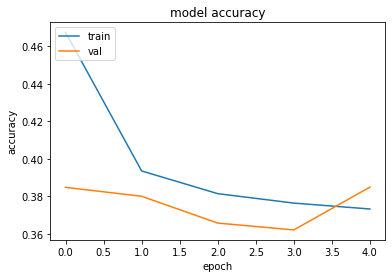

In [75]:
plt.plot(result.history['binary_crossentropy'])
plt.plot(result.history['val_binary_crossentropy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [67]:
model.evaluate(X_test, y_test)

27327/27327 [==============================] - 8s 288us/step - loss: 0.0318 - binary_crossentropy: 0.0318


[0.03180576488375664, 0.03180576488375664]

In [56]:
model.save('./saved_model/ffnn_like')

INFO:tensorflow:Assets written to: ./saved_model/ffnn_like/assets


## Predict

In [57]:
model = tf.keras.models.load_model('./saved_model/ffnn_like')

In [76]:
pred = model.predict(X_test)

In [77]:
rce = compute_rce(pred, y_test)
rce

41.345306754242486

In [78]:
average_precision_score(y_test, pred)

0.8203908417490869